- title: Pseudo online LSTM RNN - revisited
- author: Amol Kelkar
- date: 2018-10-04
- category: ai
- tags: keras, lstm, rnn, online learning

The goal of this exercise is to train an LSTM model using streaming data points $(X_t)$ to predict the next data point $(X_{t+1})$. To train the model, the input stream needs to get converted into samples over time and batches of such samples.

First, some code for plots -

In [1]:
import numpy as np
from keras import layers, models
import matplotlib.pyplot as plt


def plot_samples(samples):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_ylim(-1,1)
    
    sample0 = samples[0]
    ax.plot(sample0['data'][:,0],"--",label=sample0['name'])

    sample1 = samples[1]
    ax.plot(sample1['data'][:,0],label=sample1['name'],linewidth=3,alpha = 0.5)

    if len(samples) > 2:
        sample2 = samples[2]
        ax.plot(sample2['data'][:,0],label=sample2['name'],linewidth=2,alpha = 0.5)

    plt.legend()
    plt.show()


Using TensorFlow backend.


## Simple utility class to convert data stream to batches

In [2]:
class OnlineToBatch(object):
    def __init__(self, n_batch, t_sample, input_shape):
        self.n_batch = n_batch
        self.t_sample = t_sample
        self.input_shape = input_shape
        self.buffer = []

    def append(self, input):
        # shift left and append
        self.buffer.append(input)
        
        if len(self.buffer) == self.t_sample + self.n_batch + 1:
            batch_x = np.array([self.buffer[i:i+self.t_sample] for i in range(0, self.n_batch)]).reshape((self.n_batch, self.t_sample) + self.input_shape)
            batch_y = np.array([self.buffer[i+1:i+self.t_sample+1] for i in range(0, self.n_batch)]).reshape((self.n_batch, self.t_sample) + self.input_shape)

            self.buffer = []
            return (batch_x, batch_y)

        return None

## Create LSTM model
Here we create a simple LSTM based model to test how the OnlineToBatch drives training.

In [3]:
def define_model(t_sample,
                 n_batch,
                 data_point_shape=(1,)):


    input_layer = layers.Input(batch_shape=(None, t_sample) + data_point_shape, name="input")

    rnn = layers.LSTM(16,
                    return_sequences=True,
                    name="RNN")(input_layer)

    dense = layers.TimeDistributed(layers.Dense(np.empty(data_point_shape).size, name="dense"))(rnn)
    model = models.Model(inputs=[input_layer], outputs=[dense])

    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return model

X_t_shape = (1,)
t_sample = 100
n_batch = 200
model = define_model(t_sample = t_sample, data_point_shape = X_t_shape, n_batch = n_batch)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 100, 16)           1152      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


## Train the model on a noisy $sin$ wave input stream

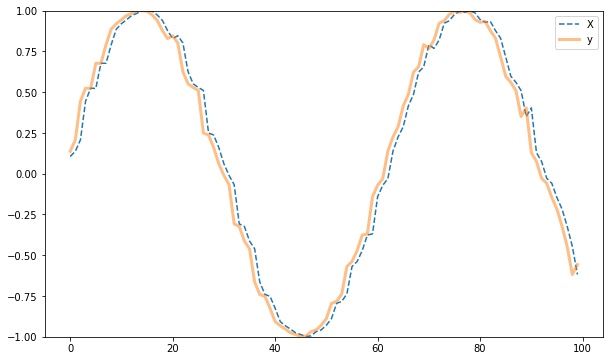

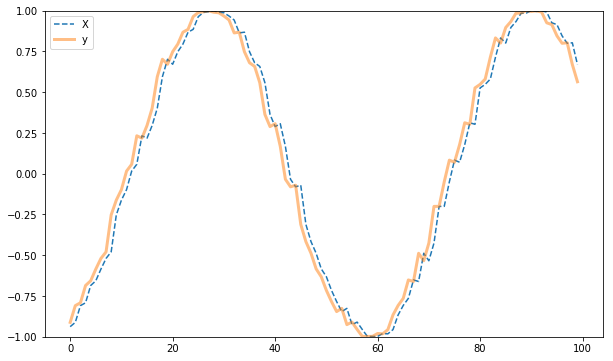

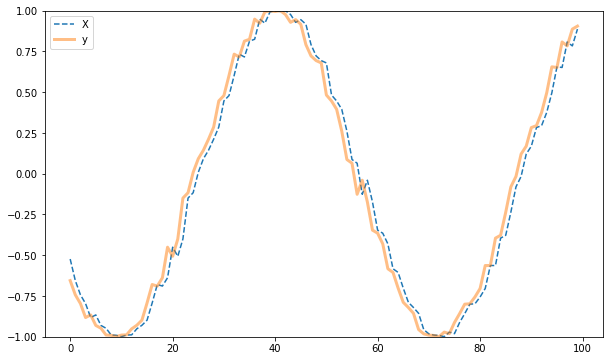

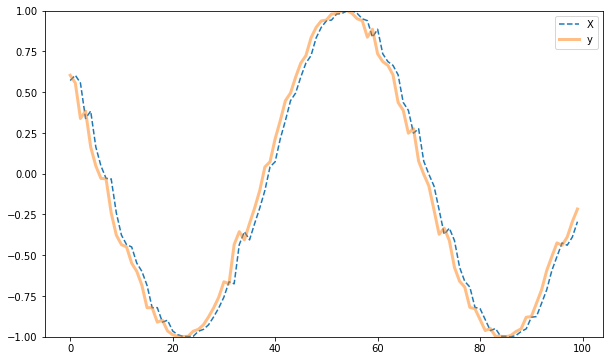

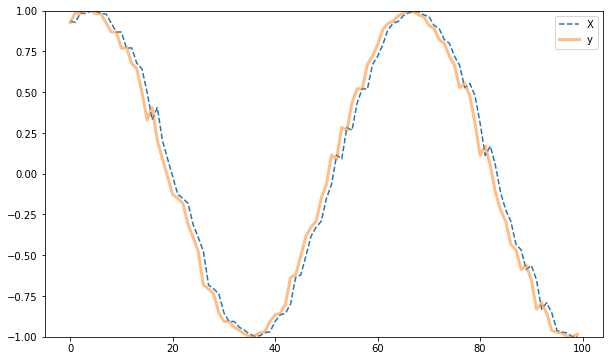

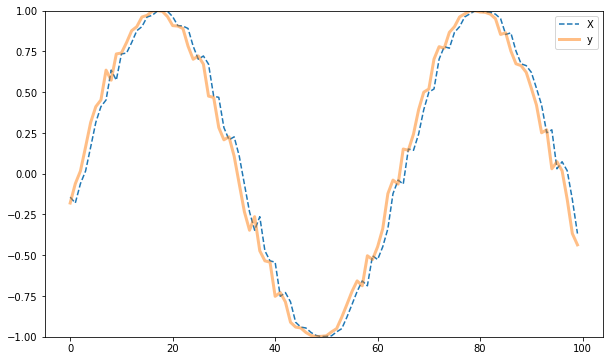

In [4]:
online_to_batch = OnlineToBatch(n_batch=n_batch, t_sample=t_sample, input_shape=X_t_shape)
last_x_batch = None
last_y_batch = None
for i in range(0, 2000):
    x = np.sin(i/10.0 + np.random.random_sample() * 0.2)
    data = online_to_batch.append(x)
    if data is not None:
        (last_x_batch, last_y_batch) = data
        plot_samples([
            {'name': 'X', 'data': last_x_batch[0]},
            {'name': 'y', 'data': last_y_batch[0]}
        ])
        model.fit(last_x_batch, last_y_batch, validation_split=0.2, epochs=20, verbose=0)




## Predict using the model

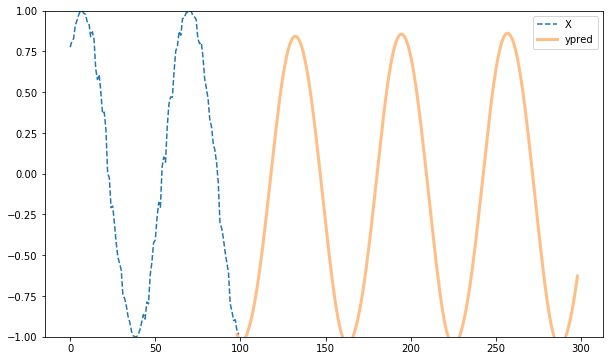

In [5]:
predict_t = t_sample * 3
test_x = np.empty((predict_t,) + X_t_shape)
test_x[0:t_sample] = last_x_batch[-1]

for i in range(predict_t - t_sample):
    pred = model.predict(np.array([test_x[i:t_sample+i]]))[0][-1]
    test_x[t_sample + i] = pred

test_x[0:t_sample-1] = np.nan
test_x = test_x[1:]

plot_samples([
    {'name': 'X', 'data': last_x_batch[-1]},
    {'name': 'ypred', 'data': test_x}
])

